<a href="https://colab.research.google.com/github/VioletaJan/Thesis_project_SynBert/blob/main/SynBERT_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load dataset
file_path = "/content/sqli-extended-cleaned.csv"
df_Vio = pd.read_csv(file_path)

df_Vio.head()


,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,%29,1
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
4,select * from users where id = '1' or @ @1 = ...,1


# Verify distribution

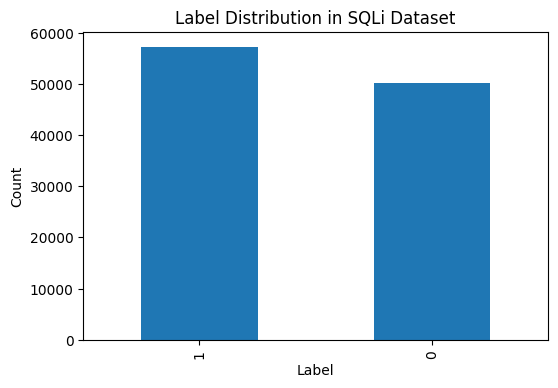

Label
1    57278
0    50163
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Count label occurrences
label_counts = df_Vio["Label"].value_counts()

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution in SQLi Dataset")
plt.show()

print(label_counts)

# Check the Class ratio
If Imbalance Ratio ≥ 0.5, the dataset is fairly balanced.
If Imbalance Ratio < 0.2, the dataset is highly imbalanced.

In [ ]:
count_1 = 57278
count_0 = 50163

# Compute imbalance ratio
imbalance_ratio = min(count_1, count_0) / max(count_1, count_0)

print(f"Imbalance Ratio: {imbalance_ratio:.3f}")

Imbalance Ratio: 0.876


#Tokenize

This approach ensures the input data is properly formatted for model processing.

Alternatives mainly involve using AutoTokenizer for flexibility or explicitly setting padding behavior.

In [ ]:
# Import the BERT tokenizer from HuggingFace Transformers library
from transformers import BertTokenizer

# Load the pretrained SynBERT tokenizer (must match the tokenizer used during model training)
tokenizer = BertTokenizer.from_pretrained("danlou/synbert")

# Define the maximum length for tokenized sequences to ensure consistent input size
max_length = 128

# Tokenize the 'Sentence' column, ensuring padding and truncation to the max length
encodings_Vio = tokenizer(
    df_Vio["Sentence"].tolist(),     # Convert DataFrame column to a list of sentences
    truncation=True,                 # Truncate sequences longer than max_length
    padding=True,                    # Pad shorter sequences to ensure uniform input size
    max_length=max_length            # Set the maximum allowed sequence length
)

print("Tokenization complete!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenization complete!


# Convert to Pytorch

In [ ]:
import torch

# Convert tokenized input IDs to PyTorch tensors for model processing
input_ids_Vio = torch.tensor(encodings_Vio["input_ids"])
# Why: The model expects inputs as tensors for efficient computation.
# Alternative: TensorFlow

# Convert attention masks to PyTorch tensors
attention_mask_Vio = torch.tensor(encodings_Vio["attention_mask"])
# Why: Attention masks indicate which tokens are actual input (1) and which are padding (0).
# Alternative: TensorFlow

# Convert labels to PyTorch tensors
labels_Vio = torch.tensor(df_Vio["Label"].tolist())
# Why: Labels are needed for supervised learning during model training.

print("\nTokenized Example:")
print(input_ids_Vio[:2])



Tokenized Example:
tensor([[  101,   107,  1137,   185,  1403,   168,  2946,   113,   168,   168,
           157, 13371,  2036,   168,   168,   114,   118,   118,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,   

# Create tensors in dataset

In [ ]:
# Import classes for handling datasets and loading them in batches
from torch.utils.data import TensorDataset, DataLoader

# Combine input tensors into a single dataset object
violetas_dataset = TensorDataset(input_ids_Vio, attention_mask_Vio, labels_Vio)
# Why: This groups input IDs, attention masks, and labels together, allowing for easy batch processing.
# Alternative: Use `torch.utils.data.Dataset` for more customized dataset handling if additional preprocessing is needed.

# Define batch size for training or evaluation
batch_size = 32

print(f"\nNew dataset is ready with {len(violetas_dataset)} samples.")



New dataset is ready with 107441 samples.


# Split the data

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine input tensors into a dataset
dataset_Violeta = TensorDataset(input_ids_Vio, attention_mask_Vio, labels_Vio)

# Define split size
train_size = int(0.6 * len(dataset_Violeta))
val_size = int(0.2 * len(dataset_Violeta))
test_size = len(dataset_Violeta) - train_size - val_size

# Split
train_dataset, val_dataset, test_dataset = random_split(dataset_Violeta, [train_size, val_size, test_size])

print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Testing set: {len(test_dataset)} samples")

Training set: 64464 samples
Validation set: 21488 samples
Testing set: 21489 samples


# Create dataloaders

In [ ]:
# Create DataLoader for the training dataset with shuffling enabled
train_dataloader = DataLoader(
    train_dataset,    # Dataset used for training
    shuffle=True,     # Shuffling helps the model generalize better by avoiding learning the order of data
    batch_size=batch_size  # Number of samples per batch
)

# Create DataLoader for the validation dataset without shuffling.
# Validation ant testing data should not be shuffled to ensure consistent metrics.
val_dataloader = DataLoader(
    val_dataset,      # Dataset used for model validation
    shuffle=False,    # No shuffling to ensure consistent evaluation
    batch_size=batch_size
)

# Create DataLoader for the testing dataset without shuffling
test_dataloader = DataLoader(
    test_dataset,     # Dataset used for final model evaluation
    shuffle=False,    # No shuffling ensures reproducible results
    batch_size=batch_size
)

print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Testing batches: {len(test_dataloader)}")


Training batches: 2015
Validation batches: 672
Testing batches: 672


# Load pretrained synBert

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("danlou/synbert", num_labels=2)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded on: {device}")

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at danlou/synbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda


# Set up optimizer AdamW

In [ ]:
# Import the AdamW optimizer (Adam with Weight Decay) from PyTorch
from torch.optim import AdamW

# Import the learning rate scheduler helper from HuggingFace
from transformers import get_scheduler

# Initialize the AdamW optimizer with model parameters
optimizer = AdamW(
    model.parameters(),  # Parameters of the model to optimize
    lr=2e-5,             # Learning rate, a common default for fine-tuning BERT
    eps=1e-8             # Epsilon to prevent division by zero in optimizer updates
)
# Why: AdamW is preferred for transformers as it handles weight decay better than the traditional Adam optimizer.

# Calculate total training steps (number of batches per epoch * number of epochs)
num_training_steps = len(train_dataloader) * 10
# Why: Required to define the total length of the learning rate schedule.

# Set up a learning rate scheduler with linear decay
lr_scheduler = get_scheduler(
    name="linear",               # Linear scheduler reduces the learning rate linearly over time
    optimizer=optimizer,         # Optimizer to apply the scheduler to
    num_warmup_steps=0,          # Number of steps for gradual warm-up (can improve model stability if set >0)
    num_training_steps=num_training_steps  # Total number of training steps
)
# Why: Helps in gradually reducing the learning rate, improving convergence.

# Define the loss function (CrossEntropy is standard for classification tasks)
loss_fn = torch.nn.CrossEntropyLoss()

print(f"Optimizer: AdamW, Learning Rate: 2e-5")
print(f"Total Training Steps: {num_training_steps}")


Optimizer: AdamW, Learning Rate: 2e-5
Total Training Steps: 20150


## Early Stopping, to prevent overfitting, if validation loss stops improving

In [ ]:
# Import NumPy for numerical operations
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pt', verbose=False):
        self.patience = patience  # Number of epochs to wait after no improvement
        self.delta = delta        # Minimum change in loss to qualify as an improvement
        self.path = path          # File path to save the best model
        self.verbose = verbose    # Whether to print messages during training
        self.counter = 0          # Counter to track epochs without improvement
        self.best_loss = np.inf   # Initialize best loss to infinity
        self.early_stop = False   # Flag to indicate whether to stop early

    # Method to be used during training
    def __call__(self, val_loss, model):
        # Check if the current validation loss is an improvement
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss          # Update best loss
            self.save_checkpoint(model)        # Save the improved model
            self.counter = 0                   # Reset the counter
        else:
            self.counter += 1                  # Increment counter if no improvement
            if self.verbose:
                # Print counter status if verbose mode is on
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # Check if the patience limit has been reached
            if self.counter >= self.patience:
                self.early_stop = True         # Trigger early stopping

    # Method to save the current model
    def save_checkpoint(self, model):
        if self.verbose:
            # Print a message when saving the model
            print(f"Validation loss decreased. Saving model to {self.path}")
        # Save the model’s state_dict to the specified path
        torch.save(model.state_dict(), self.path)


## Training and validation function

In [ ]:
import torch.nn.functional as F  # Provides common functions like activation and loss functions
from torch.utils.data import DataLoader  # Handles batching and shuffling of datasets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Metrics for model evaluation
import json  # To handle JSON data if needed for output
import seaborn as sns  # Visualization library for plots like confusion matrices
import matplotlib.pyplot as plt  # Basic plotting library
from sklearn.model_selection import cross_val_score, StratifiedKFold  # For cross-validation
from tqdm import tqdm  # For progress bars during training loops


In [ ]:
def train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_fn, lr_scheduler, epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=3, verbose=True)

    # Loop over each epoch
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        train_loss, train_correct = 0, 0  # Reset training loss and correct count for the epoch

        # Iterate through batches in the training DataLoader
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            # Move input_ids, attention_mask, and labels to the specified device (e.g., GPU)
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            # Reset gradients before backpropagation
            optimizer.zero_grad()
            # Forward pass through the model
            outputs = model(input_ids, attention_mask=attention_mask)
            # Compute loss between model predictions and true labels
            loss = loss_fn(outputs.logits, labels)
            # Backpropagate the loss
            loss.backward()
            # Update model weights
            optimizer.step()
            # Update learning rate using the scheduler
            lr_scheduler.step()
            # Accumulate total training loss
            train_loss += loss.item()
            # Count how many predictions are correct
            train_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

        # Store average training loss for the epoch
        train_losses.append(train_loss / len(train_dataloader))
        # Store training accuracy for the epoch
        train_accuracies.append(train_correct / len(train_dataloader.dataset))

        # Set the model to evaluation mode for validation
        model.eval()
        val_loss, val_correct = 0, 0  # Reset validation loss and correct count

        # Disable gradient computation for validation
        with torch.no_grad():
            # Iterate through batches in the validation DataLoader
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                # Move inputs and labels to the device
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask)
                # Compute loss
                loss = loss_fn(outputs.logits, labels)
                # Accumulate validation loss
                val_loss += loss.item()
                # Count correct predictions
                val_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

        # Store average validation loss for the epoch
        val_losses.append(val_loss / len(val_dataloader))
        # Store validation accuracy for the epoch
        val_accuracies.append(val_correct / len(val_dataloader.dataset))

        # Print training and validation performance for this epoch
        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # Check if early stopping should be triggered based on validation loss
        early_stopping(val_losses[-1], model)

        # If early stopping criterion met, break out of training loop
        if early_stopping.early_stop:
            print("Early stopping triggered! Stopping training...")
            break

    # Load the model weights from the best saved checkpoint
    model.load_state_dict(torch.load('best_model.pt'))

    return train_losses, train_accuracies, val_losses, val_accuracies


## Run training and save training and validation results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Training and validation process
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(
    model, train_dataloader, val_dataloader, optimizer, loss_fn, lr_scheduler, epochs=10, device=device
)
# Save Results as a CSV
results_df = pd.DataFrame({
    'Epoch': list(range(1, len(train_losses) + 1)),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accuracies
})
results_df.to_csv('training_results.csv', index=False)
print("Training and validation results saved to 'training_results.csv'.")

Epoch 1/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.38it/s]


Epoch 1: Train Loss: 0.5089, Train Acc: 0.6638, Val Loss: 0.6946, Val Acc: 0.5317
Validation loss decreased. Saving model to best_model.pt


Epoch 2/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.38it/s]


Epoch 2: Train Loss: 0.4881, Train Acc: 0.7120, Val Loss: 0.0779, Val Acc: 0.9828
Validation loss decreased. Saving model to best_model.pt


Epoch 3/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.37it/s]


Epoch 3: Train Loss: 0.0753, Train Acc: 0.9831, Val Loss: 0.0691, Val Acc: 0.9853
Validation loss decreased. Saving model to best_model.pt


Epoch 4/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.37it/s]


Epoch 4: Train Loss: 0.0758, Train Acc: 0.9834, Val Loss: 0.0822, Val Acc: 0.9835
EarlyStopping counter: 1 out of 3


Epoch 5/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.37it/s]


Epoch 5: Train Loss: 0.0727, Train Acc: 0.9845, Val Loss: 0.0696, Val Acc: 0.9854
EarlyStopping counter: 2 out of 3


Epoch 6/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.38it/s]


Epoch 6: Train Loss: 0.0688, Train Acc: 0.9853, Val Loss: 0.0662, Val Acc: 0.9859
Validation loss decreased. Saving model to best_model.pt


Epoch 7/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.38it/s]


Epoch 7: Train Loss: 0.0695, Train Acc: 0.9852, Val Loss: 0.0692, Val Acc: 0.9859
EarlyStopping counter: 1 out of 3


Epoch 8/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.38it/s]


Epoch 8: Train Loss: 0.0692, Train Acc: 0.9854, Val Loss: 0.0684, Val Acc: 0.9861
EarlyStopping counter: 2 out of 3


Epoch 9/10 - Validation: 100%|██████████| 672/672 [01:45<00:00,  6.37it/s]


Epoch 9: Train Loss: 0.0688, Train Acc: 0.9855, Val Loss: 0.0675, Val Acc: 0.9862
EarlyStopping counter: 3 out of 3
Early stopping triggered! Stopping training...
Training and validation results saved to 'training_results.csv'.


# Evaluation

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Define a function to evaluate and save model results
def evaluate_model(model, test_dataloader, device, output_prefix="model"):
    model.eval()
    y_true, y_pred, prob_positive = [], [], []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            # Get model outputs
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Predictions and probabilities
            probs = torch.softmax(logits, dim=1)  # get class probabilities
            predictions = logits.argmax(dim=1).cpu().numpy()
            positive_probs = probs[:, 1].cpu().numpy()  # probability of class 1

            y_pred.extend(predictions)
            y_true.extend(labels.cpu().numpy())
            prob_positive.extend(positive_probs)

    # Generate classification report and confusion matrix
    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save predictions
    df_preds = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Prob_Positive": prob_positive
    })
    df_preds.to_csv(f"{output_prefix}_predictions.csv", index=False)

    # Save classification report
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f"{output_prefix}_classification_report.csv")

    # Save confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix)
    conf_matrix_df.to_csv(f"{output_prefix}_confusion_matrix.csv", index=False)

    print(f"✅ Saved predictions, report, and confusion matrix as '{output_prefix}_*.csv'")
    return report, conf_matrix


In [ ]:
report, matrix = evaluate_model(model, test_dataloader, device, output_prefix="vio_final")



✅ Saved predictions, report, and confusion matrix as 'vio_final_*.csv'


# Save model

In [ ]:
# Save entire model
torch.save(model, "synbert_last_on_Vio.pth")
print("Model saved ")


Model saved 


In [ ]:
torch.save(model, "synbert_last_on_Vio.pth")

from google.colab import files
files.download("synbert_last_on_Vio.pth")
print("Model downloaded to Mac.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded to Mac.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "/content/drive/My Drive/models_5/synbert_model.pth"

# Ensure the directory exists
os.makedirs(os.path.dirname(drive_path), exist_ok=True)

# Save the model
torch.save(model, drive_path)
print(f" Model saved to Google Drive at {drive_path}")


# RELOAD MODEL

In [ ]:
import torch

model_path = "synbert_last_on_Vio.pth"

# Trust the file — override PyTorch's default restriction
model = torch.load(model_path, map_location="cpu", weights_only=False)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Model loaded and ready for testing!")

Model loaded and ready for testing!


# Evaluate on Sahands DS (Dataset_A)



In [ ]:
import pandas as pd

file_path = "/content/sahand_dataset_cleaned.csv"

with open(file_path, "r") as file:
  for i in range(10):
    print(file.readline().strip())

Query,Label
""" or pg_sleep  (  __TIME__  )  --",1
create user name identified by pass123 temporary tablespace temp default tablespace users;,1
" AND 1  =  utl_inaddr.get_host_address   (    (   SELECT DISTINCT  (  table_name  )   FROM   (  SELECT DISTINCT  (  table_name  )  , ROWNUM AS LIMIT FROM sys.all_tables  )   WHERE LIMIT  =  5   )    )    AND 'i'  =  'i",1
" select * from users where id  =  '1' or @ @1  =  1 union select 1,version  (    )   -- 1'",1
" select * from users where id  =  1 or 1#""  (   union select 1,version  (    )   -- 1",1
select name from syscolumns where id   =     (  select id from sysobjects where name   =   tablename'  )  --,1
select * from users where id  =  1 +$+ or 1  =  1 -- 1,1
"1;  (  load_file  (  char  (  47,101,116,99,47,112,97,115,115,119,100   )    )     )  ,1,1,1;",1
" select * from users where id  =  '1' or ||/1  =  1 union select 1,version  (    )   -- 1'",1


In [ ]:
df_Sah = pd.read_csv(file_path)

print(df_Sah.head)

<bound method NDFrame.head of                                                    Query  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30687              DELETE FROM door WHERE grow = 'small'      0
30688                               DELETE FROM tomorrow      0
30689                       SELECT wide ( s )  FROM west      0
30690        SELECT * FROM  ( SELECT slide FROM breath )      0
30691                           SELECT TOP 3 * FROM race      0

[30692 rows x 2 columns]>


# Tokenize

In [ ]:
print ("\nDataset Ifo:")
print(df_Sah.info())


Dataset Ifo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30692 entries, 0 to 30691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30691 non-null  object
 1   Label   30692 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 479.7+ KB
None


In [ ]:
df_Sah = df_Sah.dropna()

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("danlou/synbert")

max_length = 128
encodings_Sah = tokenizer(df_Sah["Query"].tolist(), truncation=True, padding=True, max_length=max_length)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Convert ti PyTorch

In [ ]:
import torch

input_ids_Sah = torch.tensor(encodings_Sah["input_ids"])
attention_mask = torch.tensor(encodings_Sah["attention_mask"])
labels_Sah = torch.tensor(df_Sah["Label"].tolist())

print("\nTokenized Example:")
print(input_ids_Sah[:2])


Tokenized Example:
tensor([[  101,   107,  1137,   185,  1403,   168,  2946,   113,   168,   168,
           157, 13371,  2036,   168,   168,   114,   118,   118,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,   

# Combine into datasets

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

sah_dataset = TensorDataset(input_ids_Sah, attention_mask, labels_Sah)

# Create Dataloader
batch_size = 16
sah_dataloader = DataLoader(sah_dataset, batch_size=batch_size, shuffle=False)

print(f"\nNew dataset is ready with {len(sah_dataset)} samples.")


New dataset is ready with 30691 samples.


# Evaluate

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Enhanced evaluation for unseen dataset
def evaluate_model_on_unseen(model, dataloader, device, output_prefix="sah"):
    model.eval()
    y_true, y_pred, prob_positive = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            predictions = logits.argmax(dim=1).cpu().numpy()
            positive_probs = probs[:, 1].cpu().numpy()

            y_pred.extend(predictions)
            y_true.extend(labels.cpu().numpy())
            prob_positive.extend(positive_probs)

    # Create predictions DataFrame and save
    df_preds = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Prob_Positive": prob_positive
    })
    df_preds.to_csv(f"{output_prefix}_predictions.csv", index=False)
    print(f"Predictions saved to {output_prefix}_predictions.csv")

    # Generate classification report and confusion matrix
    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save classification report as CSV and JSON
    pd.DataFrame(report).transpose().to_csv(f"{output_prefix}_classification_report.csv")
    with open(f"{output_prefix}_classification_report.json", "w") as json_file:
        json.dump(report, json_file, indent=4)
    print(f"Classification report saved to {output_prefix}_classification_report.(csv/json)")

    # Save confusion matrix as CSV
    pd.DataFrame(conf_matrix).to_csv(f"{output_prefix}_confusion_matrix.csv", index=False)
    print(f"Confusion matrix saved to {output_prefix}_confusion_matrix.csv")

    # Save confusion matrix as heatmap image
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {output_prefix.upper()} Dataset")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_confusion_matrix.png")
    print(f"Confusion matrix image saved to {output_prefix}_confusion_matrix.png")
    plt.show()

    return report, conf_matrix


Predictions saved to sah_predictions.csv
Classification report saved to sah_classification_report.(csv/json)
Confusion matrix saved to sah_confusion_matrix.csv
Confusion matrix image saved to sah_confusion_matrix.png


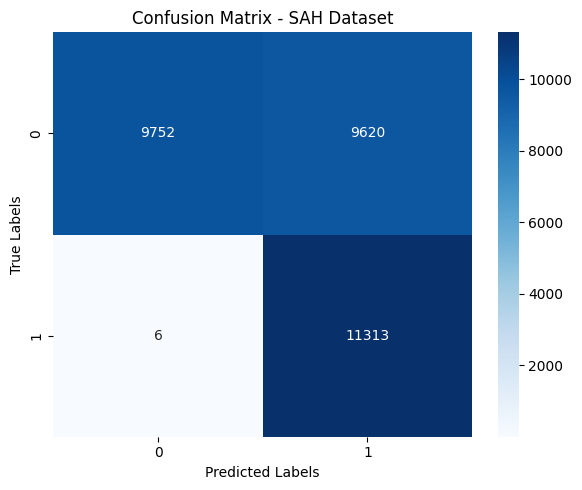

In [ ]:
report, conf_matrix = evaluate_model_on_unseen(model, sah_dataloader, device, output_prefix="sah")

# Evaluate on Jonathans

In [ ]:
import pandas as pd

file_path = "/content/jonathans_dataset.csv"

# Open and print the first few lines
with open(file_path, "r", encoding="ascii", errors="replace") as file:
    for i in range(10):
        print(file.readline().strip())

Query;Label
c/ caridad s/n;0
campello, el;0
40184;0
1442431887503330;0
nue37;0
nuda drudes;0
tufts3@joll.rs;0
22997112x;0
c/ del ferrocarril, 152,;0


In [ ]:
import pandas as pd

# Load the dataset using the correct separator
df_Jon = pd.read_csv(file_path, sep=";", encoding="ascii")

# Tokenize

In [ ]:
from transformers import BertTokenizer
import torch

# Load the trained tokenizer (same as used during training)
tokenizer = BertTokenizer.from_pretrained("danlou/synbert")

# Tokenize the SQL queries from Jonathan's dataset
max_length = 128
encodings_Jon = tokenizer(df_Jon["Query"].tolist(), truncation=True, padding=True, max_length=max_length)

# Convert to PyTorch tensors
input_ids_Jon = torch.tensor(encodings_Jon["input_ids"])
attention_mask_Jon = torch.tensor(encodings_Jon["attention_mask"])
labels_Jon = torch.tensor(df_Jon["Label"].tolist())

print(" Tokenization complete!")

 Tokenization complete!


# Dataloaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create a PyTorch dataset
jonathan_dataset = TensorDataset(input_ids_Jon, attention_mask_Jon, labels_Jon)

# Create DataLoader
batch_size = 16
jonathan_dataloader = DataLoader(jonathan_dataset, batch_size=batch_size, shuffle=False)

print(f"Testing dataset ready with {len(jonathan_dataset)} samples.")

Testing dataset ready with 30156 samples.


# Evaluate

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_on_unseen_jon(model, dataloader, device, output_prefix="jon"):
    model.eval()
    y_true, y_pred, prob_positive = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            predictions = logits.argmax(dim=1).cpu().numpy()
            positive_probs = probs[:, 1].cpu().numpy()

            y_pred.extend(predictions)
            y_true.extend(labels.cpu().numpy())
            prob_positive.extend(positive_probs)

    # Save predictions CSV
    df_preds = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Prob_Positive": prob_positive
    })
    df_preds.to_csv(f"{output_prefix}_predictions.csv", index=False)
    print(f"Predictions saved to {output_prefix}_predictions.csv")

    # Classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(f"{output_prefix}_classification_report.csv")
    with open(f"{output_prefix}_classification_report.json", "w") as json_file:
        json.dump(report, json_file, indent=4)
    print(f"Classification report saved to {output_prefix}_classification_report.(csv/json)")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    pd.DataFrame(conf_matrix).to_csv(f"{output_prefix}_confusion_matrix.csv", index=False)
    print(f"Confusion matrix saved to {output_prefix}_confusion_matrix.csv")

    # Confusion matrix heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {output_prefix.upper()} Dataset")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_confusion_matrix.png")
    print(f"Confusion matrix image saved to {output_prefix}_confusion_matrix.png")
    plt.show()

    return report, conf_matrix


Predictions saved to jon_predictions.csv
Classification report saved to jon_classification_report.(csv/json)
Confusion matrix saved to jon_confusion_matrix.csv
Confusion matrix image saved to jon_confusion_matrix.png


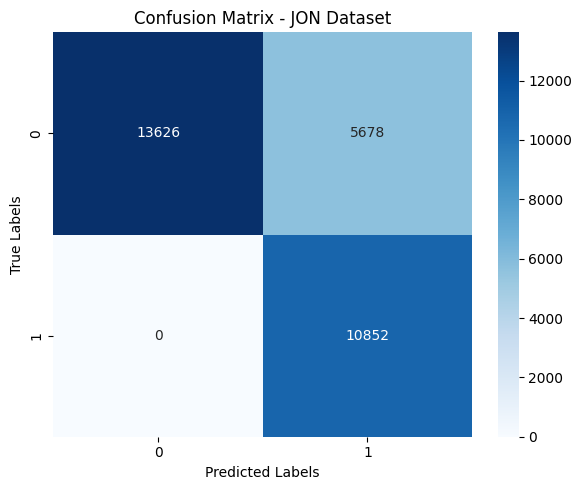

In [ ]:
report, conf_matrix = evaluate_model_on_unseen_jon(model, jonathan_dataloader, device, output_prefix="jon")

In [ ]:
report, conf_matrix = evaluate_model_on_unseen_jon(model, jon_dataloader, device)


# Tested VIO 20% (Daraset_C)

In [ ]:
import pandas as pd
from IPython.display import display

# Load classification report
report_df = pd.read_csv("vio_final_classification_report.csv", index_col=0)
print("Classification Report:")
display(report_df)

# Load confusion matrix
conf_matrix_df = pd.read_csv("vio_final_confusion_matrix.csv")
conf_matrix_df.columns = [f"Predicted {i}" for i in range(conf_matrix_df.shape[1])]
conf_matrix_df.index = [f"Actual {i}" for i in range(conf_matrix_df.shape[0])]
print("Confusion Matrix:")
display(conf_matrix_df)



Classification Report:


,precision,recall,f1-score,support
0,0.970025,0.996721,0.983192,10065.000000
1,0.997040,0.972864,0.984804,11424.000000
accuracy,0.984038,0.984038,0.984038,0.984038
macro avg,0.983532,0.984793,0.983998,21489.000000
weighted avg,0.984387,0.984038,0.984049,21489.000000


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,10032,33
Actual 1,310,11114


# Tested on Jonathans

In [ ]:
import pandas as pd
from IPython.display import display

# Load classification report
report_df = pd.read_csv("jon_classification_report.csv", index_col=0)
print("Classification Report:")
display(report_df)

# Load confusion matrix
conf_matrix_df = pd.read_csv("jon_confusion_matrix.csv")
conf_matrix_df.columns = [f"Predicted {i}" for i in range(conf_matrix_df.shape[1])]
conf_matrix_df.index = [f"Actual {i}" for i in range(conf_matrix_df.shape[0])]
print("Confusion Matrix:")
display(conf_matrix_df)


Classification Report:


,precision,recall,f1-score,support
0,1.000000,0.705864,0.827574,19304.000000
1,0.656503,1.000000,0.792637,10852.000000
accuracy,0.811712,0.811712,0.811712,0.811712
macro avg,0.828252,0.852932,0.810106,30156.000000
weighted avg,0.876389,0.811712,0.815001,30156.000000


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,13626,5678
Actual 1,0,10852


# Tested on Sahands

In [ ]:
import pandas as pd
from IPython.display import display

# Load classification report
report_df = pd.read_csv("sah_classification_report.csv", index_col=0)
print("Classification Report:")
display(report_df)

# Load confusion matrix
conf_matrix_df = pd.read_csv("sah_confusion_matrix.csv")
conf_matrix_df.columns = [f"Predicted {i}" for i in range(conf_matrix_df.shape[1])]
conf_matrix_df.index = [f"Actual {i}" for i in range(conf_matrix_df.shape[0])]
print("Confusion Matrix:")
display(conf_matrix_df)

Classification Report:


,precision,recall,f1-score,support
0,0.999385,0.503407,0.669550,19372.000000
1,0.540439,0.999470,0.701538,11319.000000
accuracy,0.686358,0.686358,0.686358,0.686358
macro avg,0.769912,0.751438,0.685544,30691.000000
weighted avg,0.830123,0.686358,0.681347,30691.000000


Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,9752,9620
Actual 1,6,11313


In [ ]:
π